# Gradient Descent

We have seen that the **training phase** of a Machine Learning model can be expressed as an **optimization problem**: given a loss function

$$
\mathcal{L}(\Theta) = \frac{1}{N}\sum_{i=1}^N \ell(f_\Theta(x^{(i)}), y^{(i)}),
$$

our goal is to find

$$
\Theta^* = \arg\min_\Theta \, \mathcal{L}(\Theta).
$$


For simple cases (like linear regression with one parameter), this minimization problem may admit a closed-form solution. In general, however, the loss function is **non-linear, high-dimensional, and often non-convex**, making analytic solutions impossible.  
We therefore rely on **iterative optimization algorithms**, the most fundamental of which is **Gradient Descent**.

## First-Order (and Second-Order) Optimality Conditions

For unconstrained, differentiable problems $ \min_\Theta \mathcal{L}(\Theta) $:

- **First-Order Necessary Condition**: any local minimizer $\Theta^*$ satisfies  
  
  $$
  \nabla_\Theta \mathcal{L}(\Theta^*) = 0.
  $$

  Points with zero gradient are called **stationary points** (they can be minima, maxima, or saddle points).

- **Second-Order Test** (when $\mathcal{L}$ is twice differentiable):  
  Let $H(\Theta) = \nabla^2_\Theta \mathcal{L}(\Theta)$ be the Hessian.  
  - If $H(\Theta^*)$ is **positive definite**, $\Theta^*$ is a **strict local minimum**.  
  - If $H(\Theta^*)$ is **indefinite**, $\Theta^*$ is a **saddle point**.  
  - If $\mathcal{L}$ is **convex**, then **any** stationary point is a **global minimum**. If it is **strictly convex**, the global minimizer is **unique**.

![](./fig/minmaxsaddle.png)

## The Gradient Descent Algorithm

### Intuition

The gradient of a differentiable function $\nabla_\Theta \mathcal{L}(\Theta)$ points in the direction of the **steepest ascent**. If we want to minimize the function, we must move in the **opposite direction**. This leads to the update rule:

$$
\Theta^{(k+1)} = \Theta^{(k)} - \eta_k \, \nabla_\Theta \mathcal{L}(\Theta^{(k)}),
$$

where $\eta_k > 0$, $k = 1, \dots, \texttt{maxit}$, is the **learning rate** (step size).

Therefore, the resulting algorithm reads:

**Input**: initial parameters $\Theta^{(0)}$, learning rate schedule $\{ \eta_k \}_k$, stopping criterion.  
**Repeat** until the stopping criterion is satisfied:
1. Compute the gradient $\nabla_\Theta \mathcal{L}(\Theta^{(k)})$.  
2. Update parameters:
   
   $$
   \Theta^{(k+1)} = \Theta^{(k)} - \eta_k \, \nabla_\Theta \mathcal{L}(\Theta^{(k)}).
   $$

```{note}
The gradient descent algorithm is an example of descent methods:

$$
\Theta^{(k+1)} = \Theta^{(k)} + \eta_k p_k, \quad k = 0, 1, \dots, \texttt{maxit},
$$

where the descent direction $p_k$ has to be chosen such that for any $k \in \mathbb{N}$:

$$
\nabla_\Theta \mathcal{L}(\Theta^{(k)})^T p_k \leq 0,
$$

to assure convergence to a stationary point. Since for GD, $p_k = - \nabla_\Theta \mathcal{L}(\Theta^{(k)})$, then the condition above is always satisfied:

$$
\nabla_\Theta \mathcal{L}(\Theta^{(k)})^T p_k = - \nabla_\Theta \mathcal{L}(\Theta^{(k)})^T \nabla_\Theta \mathcal{L}(\Theta^{(k)}) = - || \nabla_\Theta \mathcal{L}(\Theta^{(k)}) ||_2^2 \leq 0.
$$

Therefore, GD algorithm **always** converge to a stationary point in the limit of infinite iterations.
```

```{warning}
Do **not** confuse this full-batch Gradient Descent with **Stochastic Gradient Descent** (SGD), which will be introduced in the next chapter.
```

## Selection of parameters

### Choice the initial iterate

The Gradient Descent (GD) algorithm, require the user to input an initial iterate $\Theta^{(0)} \in \mathbb{R}^n$. Theoretically, since GD has a _global convergence_ proprerty, for any $\Theta^{(0)}$ it will always converge to a **stationary point** of $\mathcal{L}(\Theta)$, i.e. to a point such that $\nabla_\Theta \mathcal{L}(\Theta) = 0$.

If $\mathcal{L}(\Theta)$ is convex, then every stationary point is a (global) minimum of $\mathcal{L}(\Theta)$, implying that the choice of $\Theta^{(0)}$ is not really important, and we can always set $\Theta^{(0)} = 0$. On the other side, when $\mathcal{L}(\Theta)$ is not convex, we have to choose $\Theta^{(0)}$ such that it is as close as possible to the _right_ stationary point, to increase the chances of getting to that. If an estimate of the correct minimum point is not available, we will just consider $\Theta^{(0)} = 0$ to get to a general local minima.

### Step-Size Selection (Learning Rate)

The choice of $\{ \eta_k \}_k$ critically affects convergence.

- **Constant step size**: given a value $\eta$, set $\eta_k = \eta$ $\forall k = 1, \dots, \texttt{maxit}$. Simple, but problem-scale dependent. In particular:
  - If $\eta$ is **too small**: GD does not converge as the iterates stucks before reaching convergence;
  - If $\eta$ is **too large**: The iterates bounce back and forth around the minima, unable to reach it;
  - If $\eta$ is **just right**: The GD method converge to a stationary point, with a speed proportional to how large $\eta$ is.
  
![](./fig/right_alpha.png)

- **Backtracking line search**: for any $k \in 1, \dots, \texttt{maxit}$, set $\eta_k = \bar{\eta}$ and shrink by $\beta \in (0,1)$ until the **Armijo** condition holds:
  
  $$
  \mathcal{L}(\Theta^{(k)} - \eta g^{(k)}) \;\le\; \mathcal{L}(\Theta^{(k)}) - c\,\eta_k\,\|g^{(k)}\|^2,
  \qquad g^{(k)}=\nabla_\Theta \mathcal{L}(\Theta^{(k)}),\; c\in(0,1).
  $$

**Backtracking:**

In [1]:
import numpy as np

def backtracking(L, grad_L, theta, eta0=1.0, beta=0.5, c=1e-4):
    """
    Return a step size eta that satisfies the Armijo condition:
        L(theta - eta*g) <= L(theta) - c * eta * ||g||^2
    Inputs:
      - L:      R^n -> R
      - grad_L: R^n -> R^d
      - theta:  current point (np.ndarray)
      - eta0:   initial step size
      - beta:   shrinking factor in (0,1)
      - c:      Armijo constant in (0,1)
    """
    eta = eta0
    g = grad_L(theta)
    g_norm2 = np.dot(g, g)
    while L(theta - eta * g) > L(theta) - c * eta * g_norm2:
        eta *= beta
    return eta

### Stopping Criteria

In practice, we cannot iterate forever. Common **stopping criteria** include:
- The **norm of the gradient** is small:
  
  $$
  \|\nabla_\Theta \mathcal{L}(\Theta^{(k)})\| < \texttt{tol}_\mathcal{L},
  $$

  meaning we are close to a stationary point.  
- The **change in loss** is negligible:
  
  $$
  |\mathcal{L}(\Theta^{(k+1)}) - \mathcal{L}(\Theta^{(k)})| < \texttt{tol}_{ES}.
  $$

  named **early stopping** In ML practice (usually estimated on the validation set).

- The **parameter update** is small:
  
  $$
  \|\Theta^{(k+1)} - \Theta^{(k)}\| < \texttt{tol}_\Theta.
  $$

- A **maximum number of iterations** $\texttt{maxit}$ is reached.  

## Ill-Conditioning and Geometry

Ill-conditioning manifests as elongated level sets and **zig-zagging** GD trajectories, which makes hard for GD to reach convergence.

- Given $0<\lambda_1\ll\lambda_2$, consider the loss function:
  
  $$
  \mathcal{L}(\Theta) = \frac{1}{2} \lambda_1 \Theta_1^2 + \lambda_2 \Theta_2^2,
  $$

The level sets are ellipses whose axes scale with $\lambda_1^{-1/2}$ and $\lambda_2^{-1/2}$. When the ratio $\lambda_2/\lambda_1$ is large, Gradient Descent with a fixed $\eta$ progresses slowly and “zig-zags” across narrow valleys.

> **Exercise (condition number intuition; left-multiplication):**  
> Sketch the level sets of $\mathcal{L}(\Theta)=\tfrac{1}{2}\,\Theta^\top A\,\Theta$ for $A=\mathrm{diag}(\lambda_1,\lambda_2)$.  

**Level-set plot helper:**

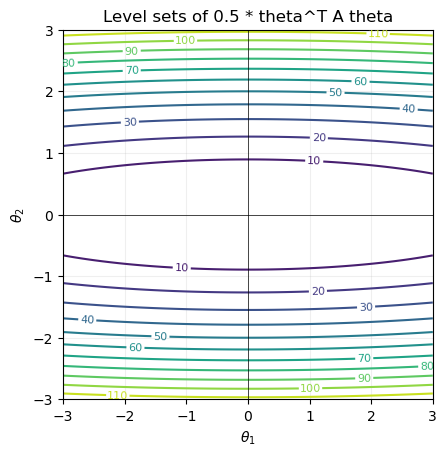

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def quad_levelsets(A, xlim=(-3,3), ylim=(-3,3), ngrid=400, ncontours=12, title=None):
    xs = np.linspace(xlim[0], xlim[1], ngrid)
    ys = np.linspace(ylim[0], ylim[1], ngrid)
    X, Y = np.meshgrid(xs, ys)
    Z = 0.5*(A[0,0]*X**2 + 2*A[0,1]*X*Y + A[1,1]*Y**2)  # theta^T A theta, left-multiplied convention
    cs = plt.contour(X, Y, Z, levels=ncontours)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.axhline(0, lw=0.5, color='k')
    plt.axvline(0, lw=0.5, color='k')
    plt.gca().set_aspect('equal', 'box')
    if title:
        plt.title(title)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.grid(alpha=0.2)
    plt.show()

# Example: ill-conditioned ellipse
A = np.diag([1.0, 25.0])  # lambda1 << lambda2
quad_levelsets(A, title='Level sets of 0.5 * theta^T A theta')

## Limitations of Pure Gradient Descent

Despite its usefulness, Gradient Descent has several drawbacks:

1. **Computationally expensive**: computing the gradient requires scanning the entire dataset at every step.  
2. **Learning rate sensitivity**: too small = slow convergence, too large = divergence/oscillations.  
3. **Local minima, saddle points, and plateaus** in non-convex landscapes.  
4. **Ill-conditioning** causes slow progress and zig-zagging.

### Motivation for Stochastic Gradient Descent

These limitations motivate more practical algorithms. In particular, instead of computing the gradient using the *entire dataset* at every iteration, one can approximate it using a **subset of the data (mini-batches)**. This gives rise to **Stochastic Gradient Descent (SGD)**, the subject of the next chapter.  

SGD addresses the scalability issue and often improves generalization, at the cost of introducing stochasticity in the updates.

In summary, **Gradient Descent** provides the foundational principles of optimization in Machine Learning:  
- It is an iterative method for minimizing loss based on **negative gradients**.  
- Its behavior hinges on **convexity/strict convexity**, **smoothness**, **step-size selection** (constant, exact line search, or **backtracking/Armijo**), and **stopping criteria**.  
- Its practical limitations naturally lead to **Stochastic Gradient Descent**, which we study next.